In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import numpy as np
from sklearn.model_selection import train_test_split
import scipy as sp
import heapq
from tqdm import tqdm_notebook as tqdm

In [2]:
df = pd.read_csv("Reddit_Election_Posts.csv")

In [3]:
def get_date(created):
    return dt.datetime.fromtimestamp(created)

In [4]:
df['url'].astype(str).str[0:]

0        https://www.reddit.com/r/Liberal/comments/9m2d...
1        https://www.reddit.com/r/Liberal/comments/9m2f...
2        https://www.reddit.com/r/Liberal/comments/9m2i...
3        https://www.reddit.com/r/Liberal/comments/9m2k...
4        https://www.reddit.com/r/Liberal/comments/9m3y...
                               ...                        
27825    http://www.openmarket.org/2012/07/10/quotas-li...
27826    http://www.marketplace.org/topics/wealth-pover...
27827    http://www.denverpost.com/politics-national/20...
27828    http://thoughtcatalog.com/2012/american-discor...
27829    https://www.reddit.com/r/moderatepolitics/comm...
Name: url, Length: 27830, dtype: object

In [5]:
#get posted date, add to df
_timestamp = df["created"].apply(get_date)
df = df.assign(timestamp = _timestamp)

#find election year
df['election year']=df['year'].astype(str).str[0:4]

In [6]:
type(str(df['body'][9]))

str

In [7]:
#feature engineering

url_agency = []
title_len = []
body_del = []
body_removed = []
body_len = []

for x in range(0,len(df)):
    #find url agency, i.e. content source
    if "www." in df['url'][x]:
        y=(df['url'][x].find("."))
        z=df['url'][x].find(".",y+1)
        url_agency.append(df['url'][x][y+1:z])
    
    elif "redd.it" in df['url'][x]:
        url_agency.append('reddit')
    elif "https://" in df['url'][x]:
        z=df['url'][x].find(".",8)
        url_agency.append(df['url'][x][8:z])
    else:
        z=df['url'][x].find(".",7)
        url_agency.append(df['url'][x][7:z])
    
    #find length of post title
    title_len.append(len(df['title'][x]))
    
    if "removed" in str(df['body'][x]):
        body_removed.append(1)
    else:
        body_removed.append(0)
        
    if "deleted" in str(df['body'][x]):
        body_del.append(1)
    else:
        body_del.append(0)

       
    body_len.append(len(str(df['body'][x])))


df['url agency']=url_agency
df['title length']=title_len
df['body removed by moderator']=body_removed
df['body deleted by user']=body_del
df['body length']=body_len

In [8]:
df.head(10)

,subreddit,year,title,score,id,url,comms_num,created,body,timestamp,election year,url agency,title length,body removed by moderator,body deleted by user,body length
0,Liberal,2018-11-06,Changing party affiliation in response to Kave...,13,9m2dtt,https://www.reddit.com/r/Liberal/comments/9m2d...,49,1.538914e+09,"Hey everyone,\n\nSo, I've long tried to be the...",2018-10-07 08:03:17,2018,reddit,51,0,0,1815
1,Liberal,2018-11-06,My mother and I have decided to cut off commun...,1,9m2f5d,https://www.reddit.com/r/Liberal/comments/9m2f...,0,1.538914e+09,[removed],2018-10-07 08:09:44,2018,reddit,65,1,0,9
2,Liberal,2018-11-06,What can I do to help?,0,9m2ixb,https://www.reddit.com/r/Liberal/comments/9m2i...,10,1.538915e+09,[deleted],2018-10-07 08:28:44,2018,reddit,22,0,1,9
3,Liberal,2018-11-06,The current World Population is estimated to b...,4,9m2kyh,https://www.reddit.com/r/Liberal/comments/9m2k...,8,1.538916e+09,[deleted],2018-10-07 08:39:28,2018,reddit,145,0,1,9
4,Liberal,2018-11-06,"С кем поведешься, от того и наберешься",1,9m3ygv,https://www.reddit.com/r/Liberal/comments/9m3y...,0,1.538935e+09,[removed],2018-10-07 13:49:12,2018,reddit,38,1,0,9
5,Liberal,2018-11-06,Was the effort of trying to stop Kavanaugh fro...,5,9m48rx,https://www.reddit.com/r/Liberal/comments/9m48...,27,1.538939e+09,[deleted],2018-10-07 14:57:37,2018,reddit,83,0,1,9
6,Liberal,2018-11-06,Can Kavanaugh be impeached?,4,9m5qno,https://www.reddit.com/r/Liberal/comments/9m5q...,21,1.538954e+09,If there's a proper investigation and it's cle...,2018-10-07 19:11:39,2018,reddit,27,0,0,133
7,Liberal,2018-11-06,This will either prove that liberals are the F...,3,9m5xj2,https://www.reddit.com/r/Liberal/comments/9m5x...,0,1.538955e+09,[removed],2018-10-07 19:36:13,2018,reddit,148,1,0,9
8,Liberal,2018-11-06,New Brunswick's 2018 Election - Explanation - ...,1,9m60wu,https://www.youtube.com/watch?v=JhVTRUyZviw,1,1.538956e+09,NaN,2018-10-07 19:48:04,2018,youtube,62,0,0,3
9,Liberal,2018-11-06,"'Let's Do This': After Owning Liberals Today, ...",0,9m62mn,https://townhall.com/tipsheet/mattvespa/2018/1...,0,1.538956e+09,NaN,2018-10-07 19:54:04,2018,townhall,109,0,0,3


In [9]:
df['subreddit'].value_counts()

Conservative        24175
Liberal              2916
moderatepolitics      739
Name: subreddit, dtype: int64

In [10]:
df['election year'].value_counts()

2018    10308
2012     7319
2016     5603
2014     4600
Name: election year, dtype: int64

## Scores and Number of Comments per Post

**Extreme Outlier Note:**
There is an extreme outlier in the conservative thread titled: "Why we won", which happened after the 2016 election. This must have happened late in the evening so that it still technically happened on the election day. 
<br>
Link [here](https://www.reddit.com/r/Conservative/comments/5c3xah/why_we_won/)

<Figure size 1332x756 with 0 Axes>

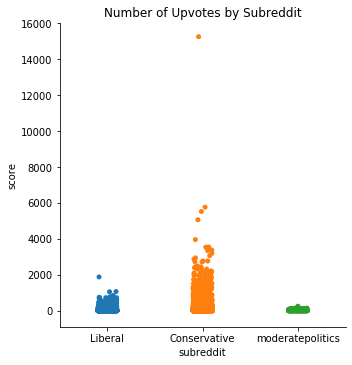

In [11]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.catplot(x="subreddit", y="score", data=df);
plt.title("Number of Upvotes by Subreddit")
plt.show()

<Figure size 1332x756 with 0 Axes>

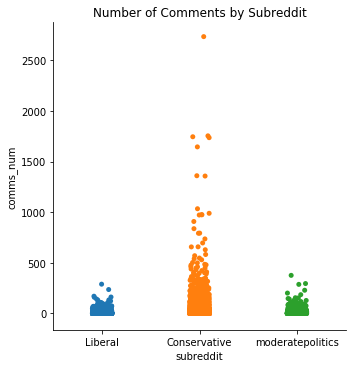

In [12]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.catplot(x="subreddit", y="comms_num", data=df);
plt.title("Number of Comments by Subreddit")
plt.show()

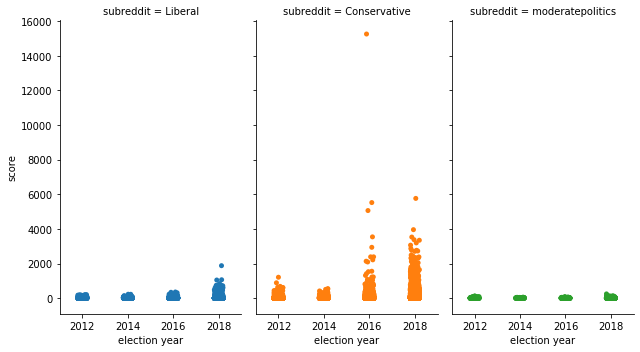

In [13]:
sns.catplot(x="election year", y="score", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);


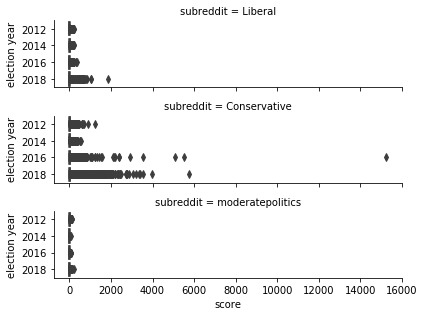

In [14]:
g = sns.catplot(x="score", y="election year", row="subreddit",
                kind="box", orient="h", height=1.5, aspect=4,
                data=df)


## Body Length & Actual Content Per Post

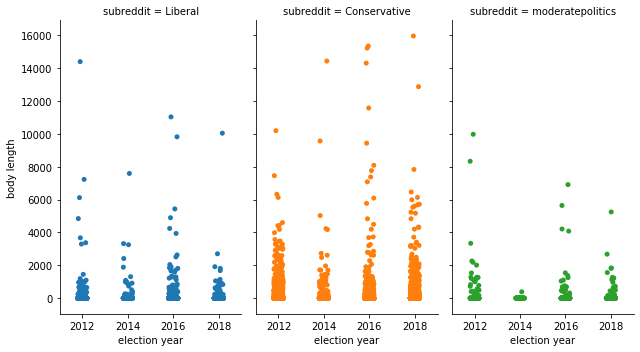

In [15]:
sns.catplot(x="election year", y="body length", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



## Overall Trends

#### Posts appear to be up to 300 characters long, which aligns fairly well with twitter specifications

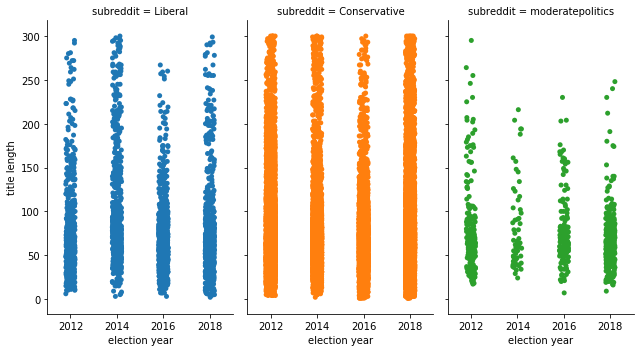

In [16]:
sns.catplot(x="election year", y="title length", hue="subreddit",
            col="subreddit", aspect=.6,
             data=df);



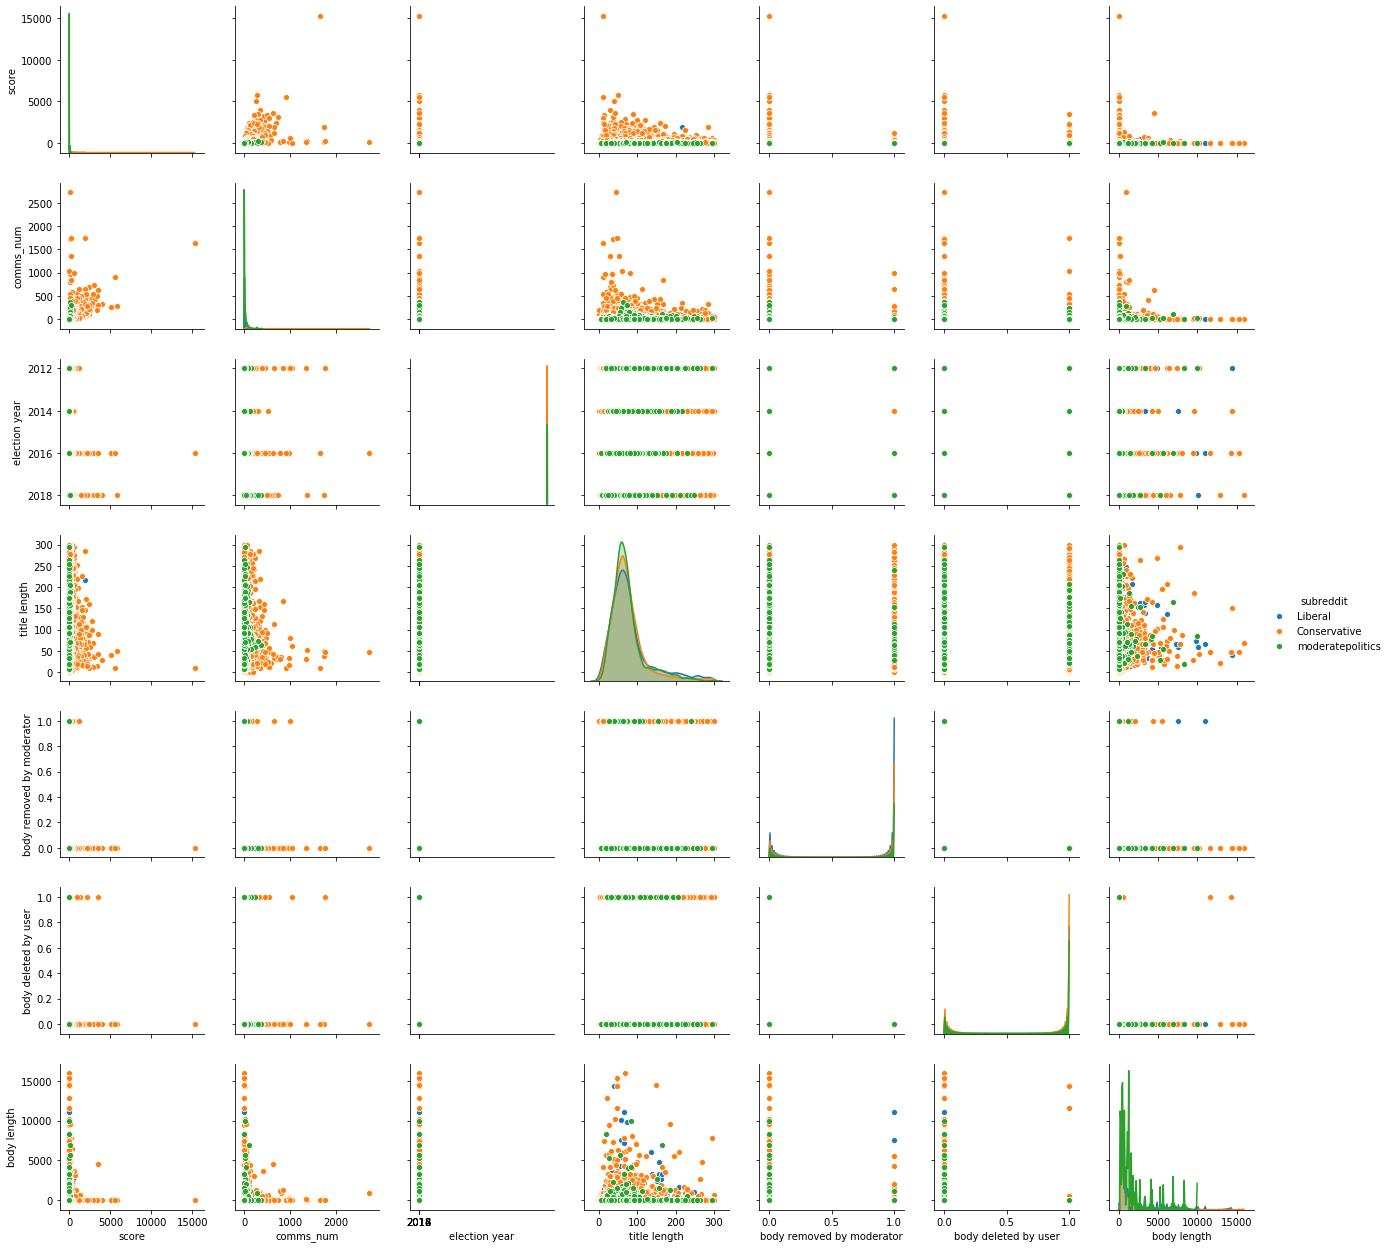

In [17]:
sns.pairplot(data=df.drop(columns=['created']), hue="subreddit");


In [18]:
subreddits = ["Conservative","Liberal","moderatepolitics"]

### News Sources

In [19]:
content_counts = df['url agency'].value_counts()

In [20]:
content_counts[0:30]

reddit                4898
youtube               1394
breitbart              872
i                      602
foxnews                562
youtu                  507
dailycaller            450
nationalreview         441
dailywire              421
thegatewaypundit       393
thehill                383
freebeacon             351
washingtonpost         348
imgur                  330
hotair                 329
nytimes                299
washingtontimes        289
washingtonexaminer     263
townhall               260
politico               247
americanthinker        222
thefederalist          213
twitter                188
realclearpolitics      186
nypost                 186
news                   181
newsbusters            179
m                      157
theblaze               157
pjmedia                155
Name: url agency, dtype: int64

Text(0.5, 0, 'characters')

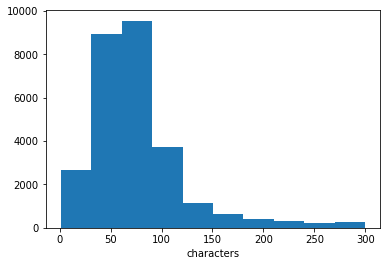

In [21]:
plt.hist(df['title length'])
plt.xlabel('characters')

In [112]:
def lexical_diversity(text):
    return len(set(text)) / len(text)
print('lexical diversity in conservative posts (*100):', lexical_diversity(df_new[df_new['class']=='Conservative'])*100)
print('lexical diversity in liberal posts (*100):', lexical_diversity(df_new[df_new['class']=='Liberal'])*100)
print('lexical diversity in moderate posts (*100):', lexical_diversity(df_new[df_new['class']=='moderatepolitics'])*100)
print('Moderate posts use a more diverse lexicon than the rest')

lexical diversity in conservative posts (*100): 0.008273009307135471
lexical diversity in liberal posts (*100): 0.06858710562414265
lexical diversity in moderate posts (*100): 0.2706359945872801
Moderate posts use a more diverse lexicon than the rest


# NLTK Analysis

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Sebastian
[nltk_data]     Acevedo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [114]:
def stringinize(df):
    comment_words = ' '
    token_list = []
    
    for x in df['title']:

        # typecaste each val to string      
        val = str(x.strip()) 

        # split the value 
        #tokens = val.split() 
        
        #tokenize
        tokens = word_tokenize(x)
        
        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        for words in tokens: 
            comment_words = comment_words + words + " "
            token_list.append(words)
    
    return comment_words, token_list

In [115]:
# make NLTK dataset for dictionaries with words for each subreddit
word_dict = { "subreddit":[], 
                "comment_words":[], 
                "token_list":[]}

for x in subreddits:
    df_temp = df.loc[df['subreddit']==x]
    
    
    word_dict["subreddit"].append(str(x))
    
    comment_words, token_list = stringinize(df_temp)
    word_dict["comment_words"].append(comment_words)
    word_dict["token_list"].append(token_list)

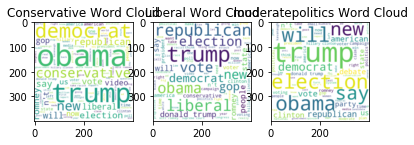

In [116]:
stopwords = set(STOPWORDS)

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

for x, y,z in zip(word_dict['comment_words'], subreddits,[ax1, ax2, ax3]):    
    wordcloud = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10,
                     collocations = True).generate(x) 
  
    # plot the WordCloud image
    #plt.figure(figsize = (5,5), facecolor = None) 
    z.set_title(str(y) + " Word Cloud")
    z.imshow(wordcloud, interpolation="bilinear")

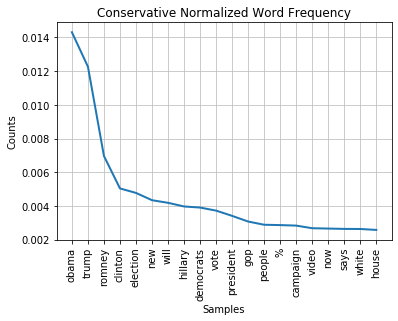

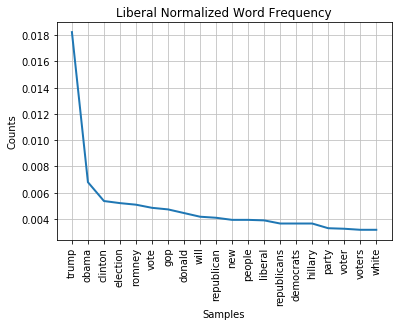

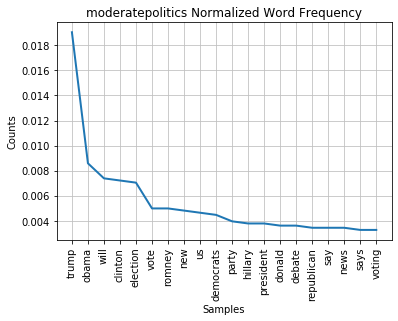

In [151]:
class_list = []
freq_list = []
word_list = []
z=0

for x, y in zip(word_dict['token_list'], subreddits):    
    filtered_sentence = [] 

    for w in x: 
        if w not in stopwords: 
            filtered_sentence.append(w) 


    fd = nltk.FreqDist(filtered_sentence)
    total = fd.N()
    for word in fd:
        fd[word] /= float(total)
    
    fd.plot(20,cumulative=False,title = str(y)+" Normalized Word Frequency")
    
    for word in fd:
        word_list.append(word)
        freq_list.append(fd[word])
        class_list.append(y)

In [153]:
freq_df = pd.DataFrame({'class':class_list,
                        "word":word_list,
                 "frequency":freq_list})

freq_df.sort_values(['frequency'], ascending = False).head(40) 

freq_df_top_conservative = freq_df.loc[freq_df['class']=='Conservative'].sort_values(by=['frequency'],ascending=False).head(30)
word_list = list(freq_df_top_conservative['word'])

top_freq_df = freq_df.loc[freq_df['word'].isin(word_list)]
top_freq_df=top_freq_df.sort_values(by=['frequency'],ascending=False)

## Plot of top 30 conservative words by ideological group

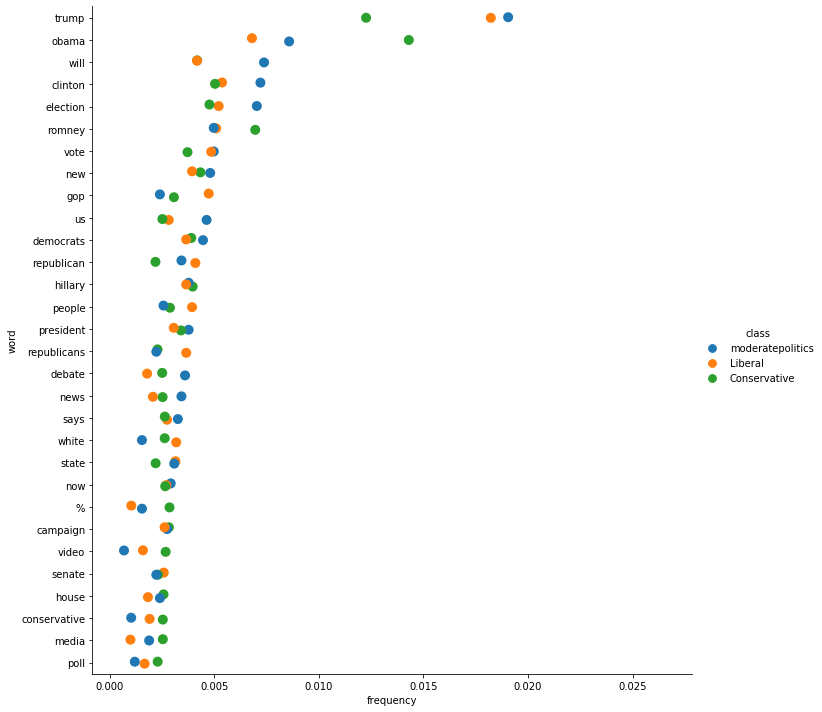

In [159]:
g=sns.catplot(y="word", x="frequency",hue="class", 
             edgecolor=".6",s=10,aspect=15/15,height=10, 
            data=top_freq_df)



In [160]:
freq_df.to_csv("Reddit Word Frequencies.csv",index=False)

# Function to generate frame of posts as rows and words as columns

In [13]:
df_new = pd.DataFrame(df['title'])
df_new['class'] = df['subreddit']

In [14]:
df_short = df_new.head(100)
#df_short.head(10)

In [16]:
stopwords = set(STOPWORDS)

for x in ['-','|','--', '$', '%', '.', ',','?',':',';',"'", '"', "'s", 's', '&', '[',']',"'m",
            '...', '(',')','!', '``','‘',"n't","’", "'"," ``","''", "”", '“','t', "'ve'"]:
    stopwords.add(x)

In [17]:
def get_tokens(df):
    tokens_clean = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        # typecaste each val to string and strip     
        val = str(x.strip())       
        #tokenize
        tokens = word_tokenize(val)
        for word in tokens:
            word = word.lower()
            if word not in stopwords:
                tokens_clean.append(word)
        
    fd = nltk.FreqDist(tokens_clean)
    return fd
        

In [18]:
wordfreq = get_tokens(df_new)
most_freq = heapq.nlargest(200, wordfreq, key=wordfreq.get)

C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
import heapq
most_freq = heapq.nlargest(10000, wordfreq, key=wordfreq.get)

In [20]:
def get_matrix(df,most_freq):    
    post_vectors = []
    for post in tqdm(range(len(df))):
        x = df['title'][post]
        val = str(x.strip())  
        post_tokens = nltk.word_tokenize(val)
        post_vec = []
        for token in most_freq:
            if token in post_tokens:
                post_vec.append(1)
            else:
                post_vec.append(0)
        post_vectors.append(post_vec)
        
    return post_vectors

In [21]:
post_matrix = get_matrix(df_new,most_freq)

C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


## Get the potentially best predictors

Now we calculate t-tests and chi-squared tests to find the words whose frequency vary the most across subreddits.

In [ ]:
post_matrix = np.asarray(post_matrix)
df_post = pd.DataFrame(post_matrix, columns = most_freq)
df_post['reddit_class'] = df_new['class']

In [71]:
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(df_post, 
                                                         df_post['reddit_class'], test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df_post['reddit_class'])

In [72]:
con = X_train[X_train['reddit_class']=='Conservative']
lib = X_train[X_train['reddit_class']=='Liberal']
mod = X_train[X_train['reddit_class']=='moderatepolitics']

In [73]:
# now we can take out the y, since we have already dividided the groups for the tests
lib = lib.loc[:, lib.columns != 'reddit_class']
mod = mod.loc[:, mod.columns != 'reddit_class']
con = con.loc[:, con.columns != 'reddit_class']

X_train = X_train.loc[:, X_train.columns != 'reddit_class']
X_test = X_test.loc[:, X_test.columns != 'reddit_class']

In [74]:
# t-test between conservative and liberal
words_t = []
t1 = []

for i in tqdm(range(len(con.columns))):
    t1.append(np.absolute(sp.stats.ttest_ind(con.iloc[:,i], lib.iloc[:,i], equal_var=False)[0]))
    
    


C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Sebastian Acevedo\Anaconda3\envs\tfcs109a\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [75]:
ordered_predictors = pd.DataFrame(most_freq, columns=['word'])
ordered_predictors['t-test'] = t1
ordered_predictors = ordered_predictors.sort_values('t-test', ascending=False)

In [81]:
ordered_predictors.head(2000)

,word,t-test
326,dead,5.835933
413,student,5.749321
670,girl,5.481337
510,probe,5.389068
1104,48,5.295200
...,...,...
5831,noncitizens,1.732140
2631,camera,1.732140
7545,smirking,1.732140
6190,directed,1.732140


In [103]:
print('differenciation ranking of word Obama:',ordered_predictors['word'].tolist().index('obama'))
print('differenciation ranking of word Trump:', ordered_predictors['word'].tolist().index('trump'))
print('In contrast to a big part of the literature, candidate names do not appear to be good predictors here')

differenciation ranking of word Obama: 6864
differenciation ranking of word Trump: 6665
In contrast to a big part of the literature, these words do not appear to be good predictors here


In [113]:
ordered_predictors.to_csv("Ordered Predictors.csv",index=False)